In [1]:
import pandas as pd

# Load Liar dataset
liar_cols = ["id", "label", "statement"]
liar_path_test = "../../dataset/test.tsv"
liar_df_test = pd.read_csv(liar_path_test, sep='\t', header=None, usecols=[0, 1, 2], names=liar_cols)
liar_path_train = "../../dataset/train.tsv"
liar_df_train = pd.read_csv(liar_path_train, sep='\t', header=None, usecols=[0, 1, 2], names=liar_cols)
liar_path_valid = "../../dataset/valid.tsv"
liar_df_valid = pd.read_csv(liar_path_valid, sep='\t', header=None, usecols=[0, 1, 2], names=liar_cols)

In [2]:
combined_liar = pd.concat([liar_df_test, liar_df_train, liar_df_valid])
combined_liar_original = combined_liar.copy
# Removing rows with missing values
combined_liar.dropna(inplace=True)
# Converting labels to numerical values
#I hate this! We lose so much information!
combined_liar['label'] = combined_liar['label'].map({'pants-fire': 0, 'false': 0, 'barely-true': 0, 'half-true': 1, 'mostly-true': 1, 'true': 1})

In [3]:
# Load FakeNewsNet dataset
#fnn_cols = ["id","news_url", "title", "tweet_id"]
fnn_cols = ["id", "statement", ]

fnn_path_gossip_fake = "../../dataset/gossipcop_fake.csv"
fnn_df_gossip_fake = pd.read_csv(fnn_path_gossip_fake, usecols=[0, 2], names=fnn_cols, header=0)
fnn_df_gossip_fake["label"] = "false"

fnn_path_gossip_real = "../../dataset/gossipcop_real.csv"
fnn_df_gossip_real = pd.read_csv(fnn_path_gossip_real, usecols=[0, 2], names=fnn_cols, header=0)
fnn_df_gossip_real["label"] = "true"

fnn_path_polit_fake = "../../dataset/politifact_fake.csv"
fnn_df_polit_fake = pd.read_csv(fnn_path_polit_fake, usecols=[0, 2], names=fnn_cols, header=0)
fnn_df_polit_fake["label"] = "false"

fnn_path_polit_real = "../../dataset/politifact_real.csv"
fnn_df_polit_real = pd.read_csv(fnn_path_polit_real, usecols=[0, 2], names=fnn_cols, header=0)
fnn_df_polit_real["label"] = "true"

In [4]:
combined_fnn  = pd.concat([fnn_df_gossip_fake, fnn_df_gossip_real, fnn_df_polit_fake, fnn_df_polit_real])
# Removing rows with missing values
combined_fnn.dropna(inplace=True)
# Converting labels to numerical values
combined_fnn['label'] = combined_fnn['label'].map({'false': 0, 'true': 1})

In [5]:
combined_liar_fnn =pd.concat([combined_liar[["id", "label", "statement"]], combined_fnn])
combined_liar_fnn_before_prepro = combined_liar_fnn.copy()

In [6]:
import string
import nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Define a function to preprocess text data
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation +'’‘“”'))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(filtered_tokens)
    
    return text

# Preprocess the text data
combined_liar_fnn['statement'] = combined_liar_fnn['statement'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text data to numerical features
vectorizer = TfidfVectorizer()
X_sparse = vectorizer.fit_transform(combined_liar_fnn['statement'])
#X = vectorizer.fit_transform(combined_liar_fnn['statement']).toarray()


# Convert the sparse matrix to a dense array in chunks
chunk_size = 1000
n_samples = X_sparse.shape[0]
n_features = X_sparse.shape[1]
X = np.zeros((n_samples, n_features))

for i in range(0, n_samples, chunk_size):
    X[i:i+chunk_size, :] = X_sparse[i:i+chunk_size, :].toarray()

print(X_sparse[:10])

## PreProcessing Part is done here. 

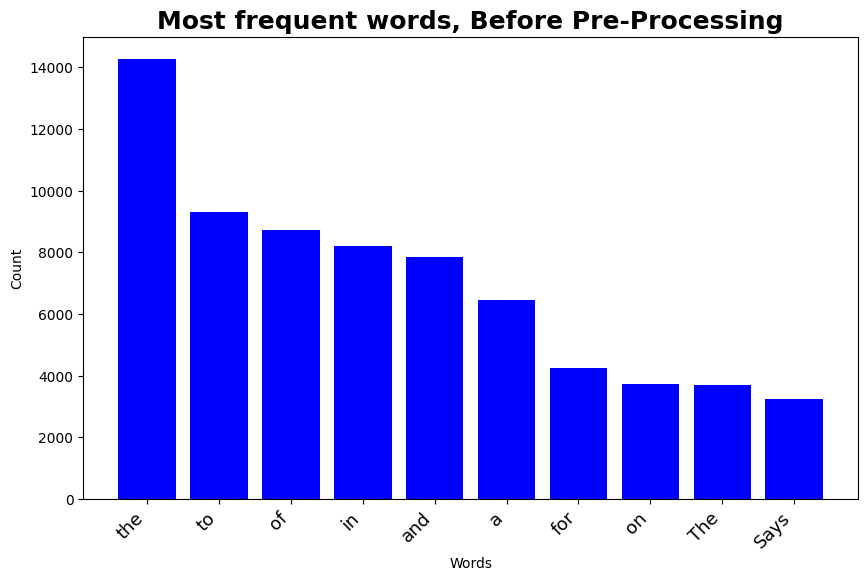

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine all statements into one string
all_statements = " ".join(combined_liar_fnn_before_prepro["statement"].values)

# Count the frequency of each word
word_counts = pd.Series(all_statements.split()).value_counts()[:10]

# Plot the most frequent words
plt.figure(figsize=(10,6))
plt.bar(word_counts.index, word_counts.values, color="blue")
plt.title("Most frequent words, Before Pre-Processing",  fontsize=18, fontweight='bold')
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right", fontsize=13)
plt.show()


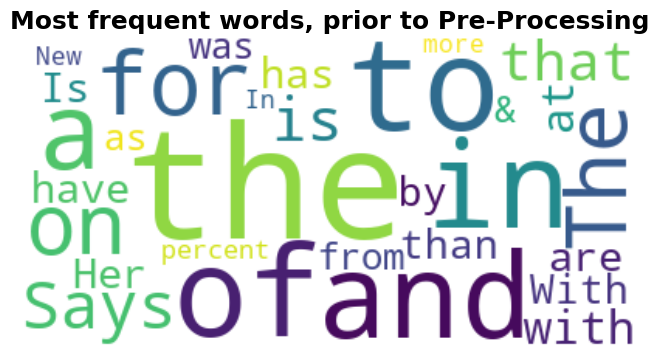

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all statements into one string
all_statements = " ".join(combined_liar_fnn_before_prepro["statement"].values)

# Count the frequency of each word
word_counts = pd.Series(all_statements.split()).value_counts()[:30]

# Generate a wordcloud of the most frequent words
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_counts)

# Plot the wordcloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most frequent words, prior to Pre-Processing", fontsize=18, fontweight='bold')
plt.show()


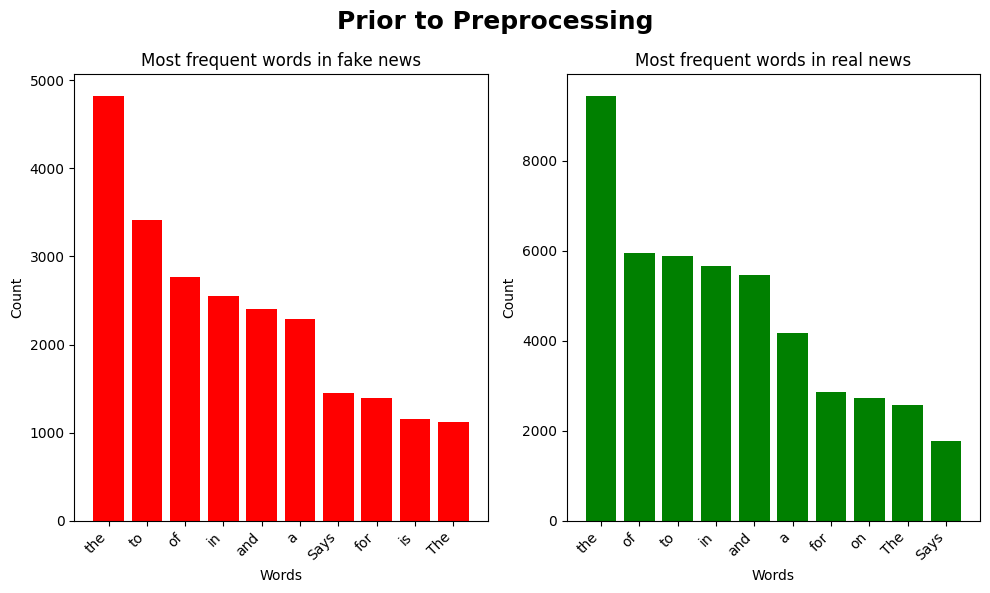

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the most frequent words in fake news
fake_df = combined_liar_fnn_before_prepro[combined_liar_fnn_before_prepro["label"] == 0]
fake_words = " ".join(fake_df["statement"].values)
fake_word_counts = pd.Series(fake_words.split()).value_counts()[:10]
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.bar(fake_word_counts.index, fake_word_counts.values, color="red")
plt.title("Most frequent words in fake news")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

# Plot the most frequent words in real news
real_df = combined_liar_fnn_before_prepro[combined_liar_fnn_before_prepro["label"] == 1]
real_words = " ".join(real_df["statement"].values)
real_word_counts = pd.Series(real_words.split()).value_counts()[:10]
plt.subplot(1, 2, 2)
plt.bar(real_word_counts.index, real_word_counts.values, color="green")
plt.title("Most frequent words in real news")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

# Add a common figure title
fig = plt.gcf()
fig.suptitle("Prior to Preprocessing",  fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()


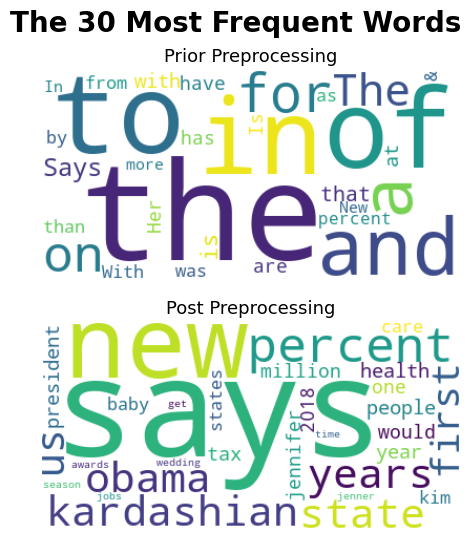

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

# Generate wordcloud for before pre-processing
all_statements_before = " ".join(combined_liar_fnn_before_prepro["statement"].values)
word_counts_before = pd.Series(all_statements_before.split()).value_counts()[:30]
wordcloud_before = WordCloud(background_color="white").generate_from_frequencies(word_counts_before)
axes[0].imshow(wordcloud_before, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("Prior Preprocessing", fontsize=13)

# Generate wordcloud for after pre-processing
all_statements_after = " ".join(combined_liar_fnn["statement"].values)
word_counts_after = pd.Series(all_statements_after.split()).value_counts()[:30]
wordcloud_after = WordCloud(background_color="white").generate_from_frequencies(word_counts_after)
axes[1].imshow(wordcloud_after, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Post Preprocessing", fontsize=13)

# Set a common title for the entire figure
fig.suptitle("The 30 Most Frequent Words", fontsize=20, fontweight='bold')

# Display the plot
plt.show()


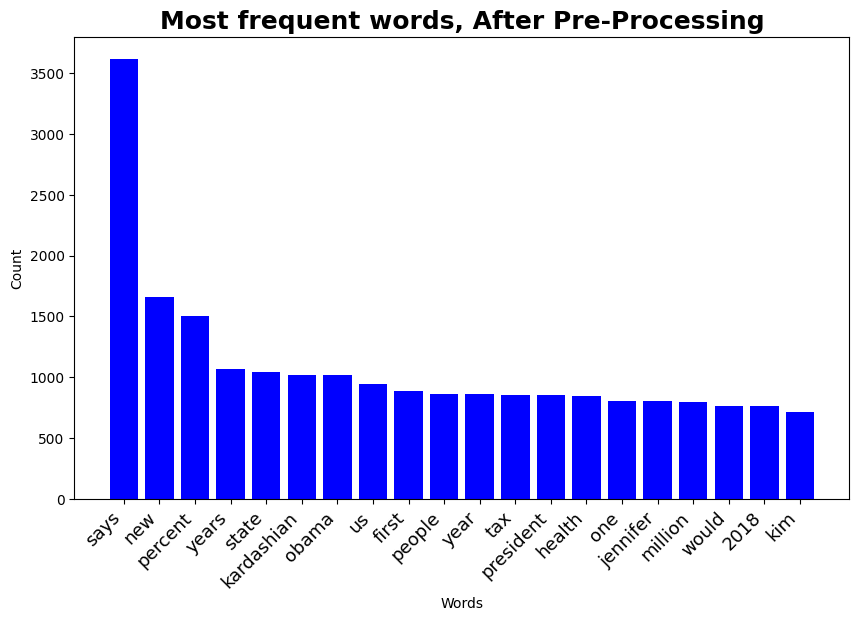

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine all statements into one string
all_statements = " ".join(combined_liar_fnn["statement"].values)

# Count the frequency of each word
word_counts = pd.Series(all_statements.split()).value_counts()[:20]

# Plot the most frequent words
plt.figure(figsize=(10,6))
plt.bar(word_counts.index, word_counts.values, color="blue")
plt.title("Most frequent words, After Pre-Processing",  fontsize=18, fontweight='bold')
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right", fontsize=13)
plt.show()

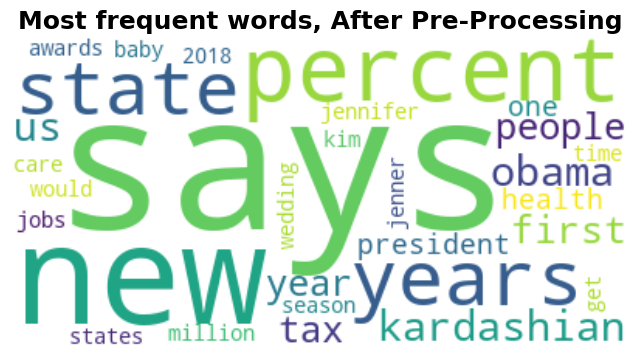

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all statements into one string
all_statements = " ".join(combined_liar_fnn["statement"].values)

# Count the frequency of each word
word_counts = pd.Series(all_statements.split()).value_counts()[:30]

# Generate a wordcloud of the most frequent words
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_counts)

# Plot the wordcloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most frequent words, After Pre-Processing", fontsize=18, fontweight='bold')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the most frequent words in fake news
fake_df = combined_liar_fnn[combined_liar_fnn["label"] == 0]
fake_words = " ".join(fake_df["statement"].values)
fake_word_counts = pd.Series(fake_words.split()).value_counts()[:10]
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.bar(fake_word_counts.index, fake_word_counts.values, color="red")
plt.title("Most frequent words in fake news")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

# Plot the most frequent words in real news
real_df = combined_liar_fnn[combined_liar_fnn["label"] == 1]
real_words = " ".join(real_df["statement"].values)
real_word_counts = pd.Series(real_words.split()).value_counts()[:10]
plt.subplot(1, 2, 2)
plt.bar(real_word_counts.index, real_word_counts.values, color="green")
plt.title("Most frequent words in real news")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

# Add a common figure title
fig = plt.gcf()
fig.suptitle("After Pre-Processing",  fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer


# Calculate TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf.fit_transform(combined_liar_fnn['statement'])

# Convert TF-IDF matrix to dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
# Apply TF-IDF vectorization to the text data
#tfidf = TfidfVectorizer(stop_words='english', max_features=100)
#tfidf = vectorizer.fit_transform(combined_liar_fnn["statement"])

# Convert the TF-IDF matrix to a DataFrame
#tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())
# Compute the sum of TF-IDF scores for each word across all documents
word_scores = tfidf_df.sum().sort_values(ascending=False)

# Plot the top 10 most frequent words
plt.figure(figsize=(10,6))
plt.bar(word_scores[:20].index, word_scores[:20].values, color="blue")
plt.title("Top 20 Most Frequent Words (weighted by TF-IDF)")
#plt.xlabel("Words")
plt.ylabel("TF-IDF score sum")
plt.xticks(rotation=45, ha="right")

# Add a figure title
fig = plt.gcf()
#fig.suptitle("After TF-IDF Vectorization",  fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer


# Calculate TF-IDF
#tfidf = TfidfVectorizer(stop_words='english', max_features=100)
#tfidf_matrix = tfidf.fit_transform(combined_liar_fnn['statement'])

# Convert TF-IDF matrix to dataframe
#tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Add labels to the dataframe
tfidf_df['label'] = combined_liar_fnn['label'].values

# Plot the most frequent words in fake news after using TF-IDF
fake_df = tfidf_df[tfidf_df['label'] == 0]
fake_word_counts = fake_df.drop('label', axis=1).sum().sort_values(ascending=False)[:10]
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.bar(fake_word_counts.index, fake_word_counts.values, color="red")
plt.title("Most frequent words in fake news (after TF-IDF)")
plt.xlabel("Words")
plt.ylabel("TF-IDF score")
plt.xticks(rotation=45, ha="right")

# Plot the most frequent words in real news after using TF-IDF
real_df = tfidf_df[tfidf_df['label'] == 1]
real_word_counts = real_df.drop('label', axis=1).sum().sort_values(ascending=False)[:10]
plt.subplot(1, 2, 2)
plt.bar(real_word_counts.index, real_word_counts.values, color="green")
plt.title("Most frequent words in real news (after TF-IDF)")
plt.xlabel("Words")
plt.ylabel("TF-IDF score")
plt.xticks(rotation=45, ha="right")

# Add a common figure title
fig = plt.gcf()
fig.suptitle("After using TF-IDF", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the most frequent words in fake news
fake_df = combined_liar_fnn[combined_liar_fnn["label"] == 0]
fake_words = " ".join(fake_df["statement"].values)
fake_word_counts = pd.Series(fake_words.split()).value_counts()[:10]
plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
plt.bar(fake_word_counts.index, fake_word_counts.values, color="red")
plt.title("fake news")

plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

# Plot the most frequent words in real news
real_df = combined_liar_fnn[combined_liar_fnn["label"] == 1]
real_words = " ".join(real_df["statement"].values)
real_word_counts = pd.Series(real_words.split()).value_counts()[:10]
plt.subplot(2, 2, 2)
plt.bar(real_word_counts.index, real_word_counts.values, color="green")
plt.title("real news")

plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

# Add a common figure title
fig = plt.gcf()
fig.suptitle("Before Pre-Processing", fontsize=18, fontweight='bold')

# Plot the most frequent words in fake news after using TF-IDF
fake_df = tfidf_df[tfidf_df['label'] == 0]
fake_word_counts = fake_df.drop('label', axis=1).sum().sort_values(ascending=False)[:10]
plt.subplot(2, 2, 3)
plt.bar(fake_word_counts.index, fake_word_counts.values, color="red")
plt.title("fake news (weighted by TF-IDF)")

plt.ylabel("TF-IDF score")
plt.xticks(rotation=45, ha="right")

# Plot the most frequent words in real news after using TF-IDF
real_df = tfidf_df[tfidf_df['label'] == 1]
real_word_counts = real_df.drop('label', axis=1).sum().sort_values(ascending=False)[:10]
plt.subplot(2, 2, 4)
plt.bar(real_word_counts.index, real_word_counts.values, color="green")
plt.title("real news (weighted by TF-IDF)")

plt.ylabel("TF-IDF score")
plt.xticks(rotation=45, ha="right")

# Add a common figure title
fig = plt.gcf()
fig.suptitle("Most frequent words", fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set the order of the labels
order = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']

# Create histogram
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.countplot(x="label", data=combined_liar, palette=sns.color_palette("RdYlGn_r", n_colors=6)[::-1], order=order)

# Add text annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 50, int(height), ha="center")

plt.title("Distribution of Labels in Liar Dataset")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


In [ ]:

# Count the number of fake and true news in each dataset
liar_counts = combined_liar['label'].value_counts()
fnn_counts = combined_fnn['label'].value_counts()
liar_fnn_counts = combined_liar_fnn['label'].value_counts()

# Create a bar plot
fig, ax = plt.subplots()
ax.bar(['Liar', 'FakeNewsNet', 'Liar + FakeNewsNet'], [liar_counts[0], fnn_counts[0], liar_fnn_counts[0]], label='False', color='tab:red')
ax.bar(['Liar', 'FakeNewsNet', 'Liar + FakeNewsNet'], [liar_counts[1], fnn_counts[1], liar_fnn_counts[1]], bottom=[liar_counts[0], fnn_counts[0], liar_fnn_counts[0]], label='True', color='tab:green')

# Add text annotations to display the counts
for i, count in enumerate([liar_counts, fnn_counts, liar_fnn_counts]):
    total_count = count[0] + count[1]
    ax.text(i, count[0]/2, f"{count[0]}", ha='center')
    ax.text(i, count[0] + count[1]/2, f"{count[1]}", ha='center')
    ax.text(i, count[0] + count[1] + 50, f"{total_count} Total ", ha='center')

ax.set_xlabel('Dataset')
ax.set_ylabel('Number of news')
ax.legend(title='Label', loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Number of False and True News in the Datasets', fontsize=14, fontweight='bold')
plt.show()


In [ ]:
# Extract dataset identifier from filename
fnn_df['dataset'] = fnn_df['id'].str.extract('(gossipcop|politifact)')
fnn_df['label'] = fnn_df['label'].replace({'true': 'Real', 'false': 'Fake'})

# Set the order of the labels
order = ['Fake', 'Real']

# Create plot
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.countplot(x="dataset", hue="label", data=fnn_df, palette={"Fake": "red", "Real": "green"}, order=['gossipcop', 'politifact'])

# Add text annotations
# Add text annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{}'.format(int(height)),
            ha="center") 

# Set plot labels and legend
ax.set_title("Fake News Net Dataset")
ax.set_xlabel("Dataset")
ax.set_ylabel("Count")
ax.legend(title="Label")

plt.show()


In [ ]:
fnn_df = pd.concat([fnn_df_gossip_fake, fnn_df_gossip_real, fnn_df_polit_fake, fnn_df_polit_real])
# Set the order of the labels
order = ['false', 'true']

# Create two subplots side by side
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

# Plot the distribution of labels for the GossipCop dataset
sns.countplot(x="label", data=fnn_df[fnn_df['id'].str.contains("gossipcop")], palette=["red", "green"], order=order, ax=axs[0])
axs[0].set_title("GossipCop Dataset")
axs[0].set_xlabel("Label")
axs[0].set_ylabel("Count")

# Plot the distribution of labels for the Politifact dataset
sns.countplot(x="label", data=fnn_df[fnn_df['id'].str.contains("politifact")],  palette=["red", "green"], order=order, ax=axs[1])
#ax = sns.countplot(x="label", data=combined_liar, palette=sns.color_palette("RdYlGn_r", n_colors=6)[::-1], order=order)
axs[1].set_title("Politifact Dataset")
axs[1].set_xlabel("Label")
axs[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## The next cells is only for understanding the vectorized new data, but can be deleted in the end. 

In [ ]:
#vocab = vectorizer.get_feature_names_out()
vocab = vectorizer.get_feature_names()

# Define the target variable
y = np.array([1 if label in [1] else 0 for label in combined_liar_fnn['label']])


print(X.shape)
j= 0
for i in X[0]:
    if i != 0: print(i, j, vocab[j])
    j =j+1
combined_liar_fnn['statement'][0]

## Example how pre-processed data could be used

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the data into training and testing sets
split = int(0.8 * len(combined_liar_fnn))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

# Train the Logistic Regression classifier
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lr.predict(X_test)

# Compute the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

In [ ]:
y_pred

In [ ]:
# Define a new statement
new_statement1 = ['Hillary buys russian lamps.']
new_statement2 = ['Trump builds a wall']
new_statement3 = ['Covid is back.']

# Preprocess the text data
new_statement = [preprocess_text(statement) for statement in new_statement1]

# Convert the text data to numerical features
new_features = vectorizer.transform(new_statement).toarray()

# Make a prediction using the trained model
prediction = lr.predict(new_features)[0]
print(prediction)

if prediction == 1:
    print('This statement is deceptive.')
else:
    print('This statement is truthful.')